In [12]:
#IMPORTING Celeba DATASET from kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [2]:
!pip install torch torchvision numpy matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [13]:
import os

path = "/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba"  # Replace with your path

if os.path.exists(path):
    print("Path exists!")
else:
    print("Path does NOT exist!")


Path exists!


In [20]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset

# Define transformations based on the DCGAN paper
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to 64x64
    transforms.CenterCrop(64),  # Crop the center
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load the CelebA dataset
dataset = datasets.ImageFolder(root="/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba", transform=transform)

# Limit dataset to first 5000 images
subset_indices = list(range(5000))  # Select the first 5000 images
small_dataset = Subset(dataset, subset_indices)  # Create subset

# Create a new DataLoader for the smaller dataset
dataloader = DataLoader(small_dataset, batch_size=128, shuffle=True)

# Check the dataset
real_batch = next(iter(dataloader))
print("Batch shape:", real_batch[0].shape)  # Expected: (batch_size, 3, 64, 64)
print(f"Total images in dataloader: {len(small_dataset)}")  # Should print 500


Batch shape: torch.Size([128, 3, 64, 64])
Total images in dataloader: 5000


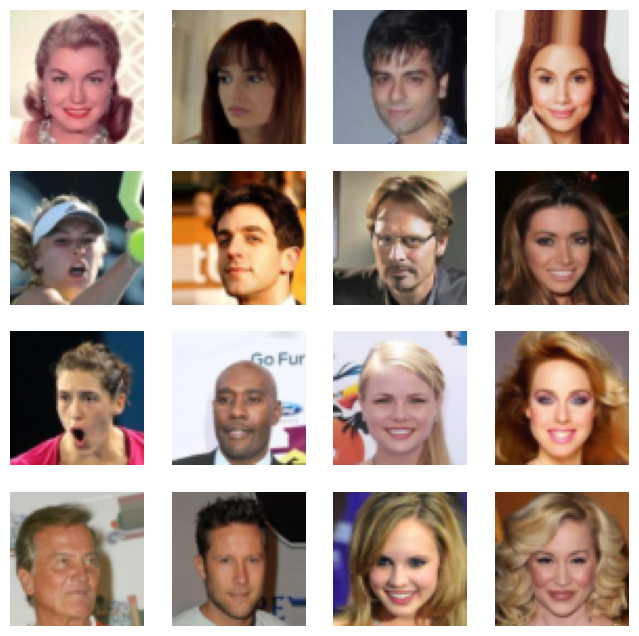

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
real_batch = next(iter(dataloader))  # Fetch one batch
images = real_batch[0]  # Extract images (ignore labels)

# Convert images from [-1, 1] to [0, 1] for proper visualization
images = images * 0.5 + 0.5  # Undo normalization
images = images.numpy()  # Convert to NumPy array

# Function to show images in a grid
def show_images(images, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        img = np.transpose(images[i], (1, 2, 0))  # Change shape from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.axis("off")  # Hide axes
    plt.show()

# Display the images
show_images(images)


In [16]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent vector z (100,)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        return self.main(x)


In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output: Probability of real vs. fake
        )

    def forward(self, x):
        return self.main(x)


In [18]:
import torch.optim as optim

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers (following the DCGAN paper)
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))




Epoch [1/50], Loss D: 0.90797358751297, Loss G: 3.299938678741455
Epoch [2/50], Loss D: 0.5052367448806763, Loss G: 3.801635265350342
Epoch [3/50], Loss D: 0.5708237886428833, Loss G: 0.8700822591781616
Epoch [4/50], Loss D: 0.871033251285553, Loss G: 1.4919734001159668
Epoch [5/50], Loss D: 0.5494105815887451, Loss G: 5.617632865905762


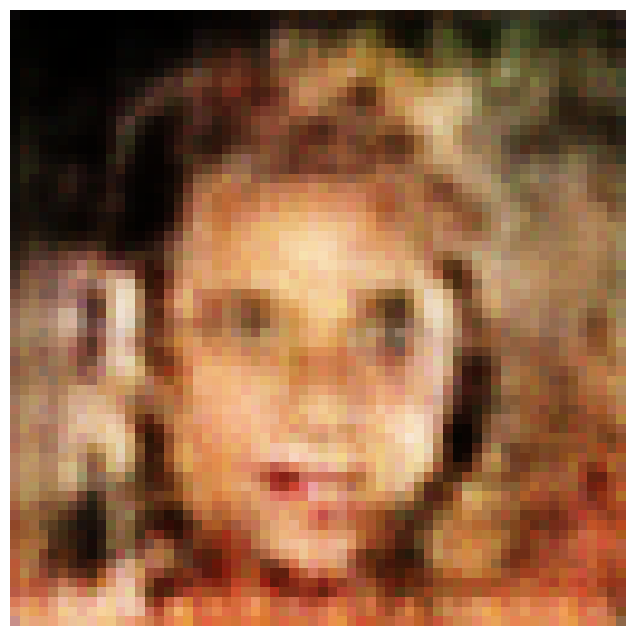

Epoch [6/50], Loss D: 0.36928224563598633, Loss G: 3.193898916244507
Epoch [7/50], Loss D: 0.47666966915130615, Loss G: 2.983189105987549
Epoch [8/50], Loss D: 0.2693518400192261, Loss G: 4.903164863586426
Epoch [9/50], Loss D: 0.7660709023475647, Loss G: 4.302185535430908
Epoch [10/50], Loss D: 0.669282078742981, Loss G: 8.188421249389648


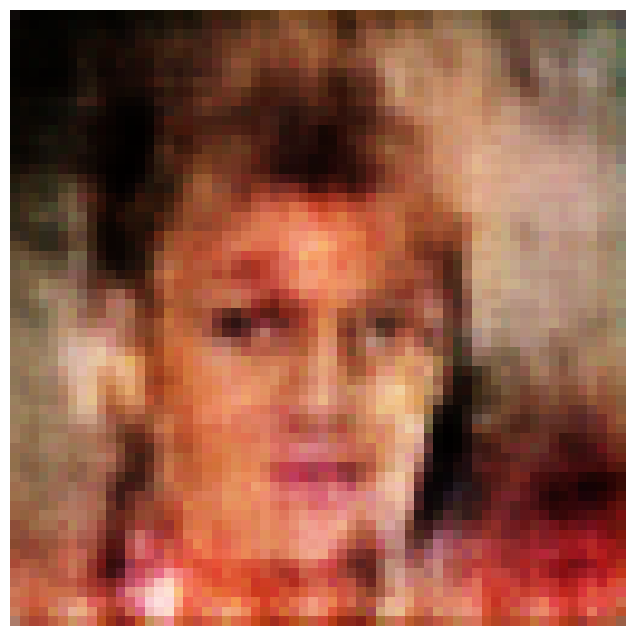

Epoch [11/50], Loss D: 0.4452252984046936, Loss G: 3.3039603233337402
Epoch [12/50], Loss D: 0.420867919921875, Loss G: 6.698166847229004
Epoch [13/50], Loss D: 0.23442521691322327, Loss G: 4.872470855712891
Epoch [14/50], Loss D: 0.44917261600494385, Loss G: 2.2236311435699463
Epoch [15/50], Loss D: 0.43772298097610474, Loss G: 3.788648843765259


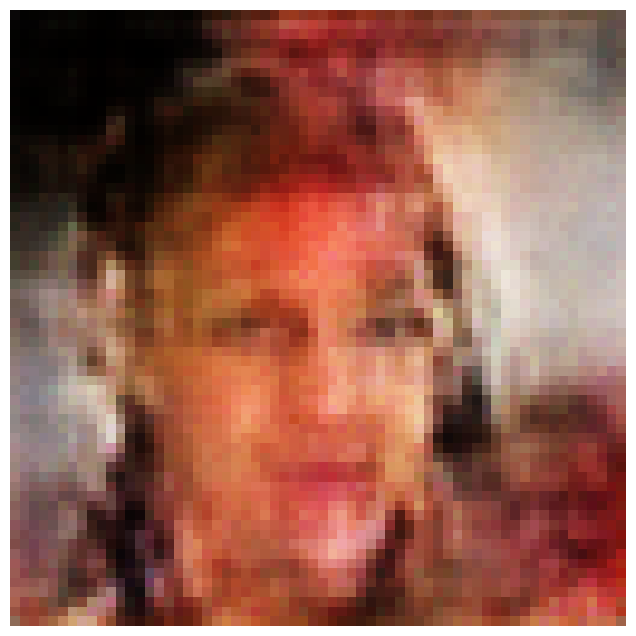

Epoch [16/50], Loss D: 0.5080756545066833, Loss G: 9.056694030761719
Epoch [17/50], Loss D: 2.2668120861053467, Loss G: 0.5413576364517212
Epoch [18/50], Loss D: 0.6250442266464233, Loss G: 2.0848376750946045
Epoch [19/50], Loss D: 1.5008124113082886, Loss G: 0.33557653427124023
Epoch [20/50], Loss D: 0.16417260468006134, Loss G: 5.507049560546875


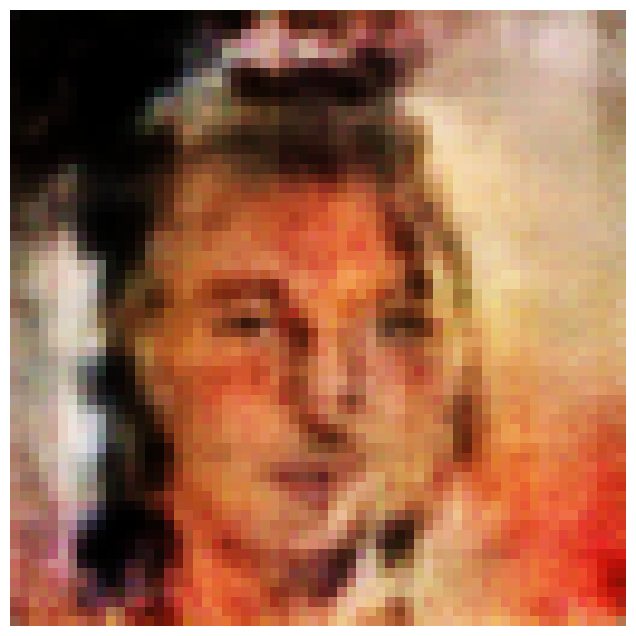

Epoch [21/50], Loss D: 0.33325910568237305, Loss G: 4.681225776672363
Epoch [22/50], Loss D: 0.263629674911499, Loss G: 4.486473083496094
Epoch [23/50], Loss D: 0.5575903654098511, Loss G: 4.442000865936279
Epoch [24/50], Loss D: 0.6806710958480835, Loss G: 10.738265991210938
Epoch [25/50], Loss D: 0.2960719168186188, Loss G: 3.0486137866973877


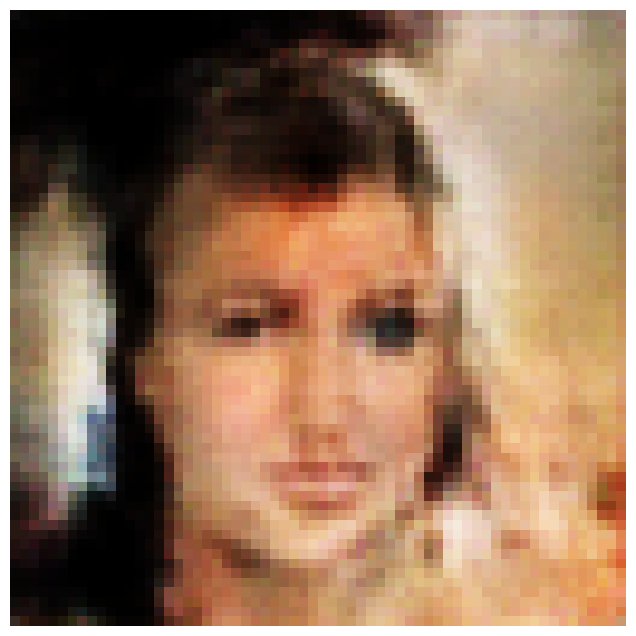

Epoch [26/50], Loss D: 2.341048002243042, Loss G: 0.06347322463989258
Epoch [27/50], Loss D: 0.6625956892967224, Loss G: 2.380326747894287
Epoch [28/50], Loss D: 0.5254882574081421, Loss G: 1.8199700117111206
Epoch [29/50], Loss D: 0.7765918970108032, Loss G: 2.1264970302581787
Epoch [30/50], Loss D: 0.20795445144176483, Loss G: 6.180978775024414


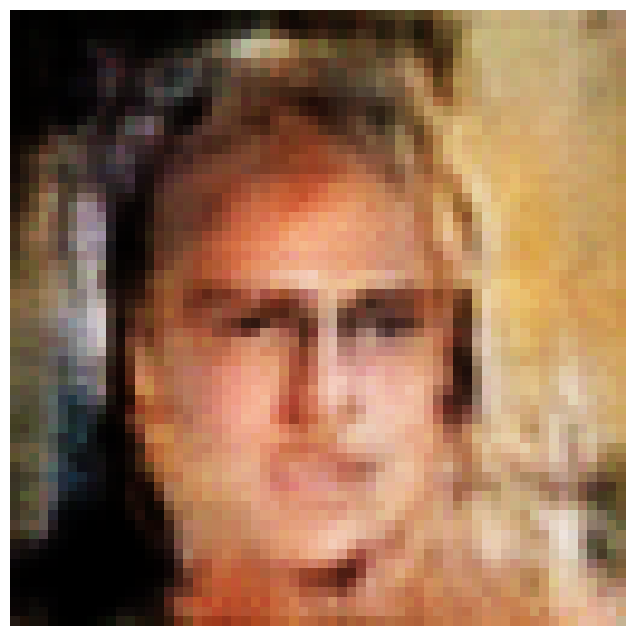

Epoch [31/50], Loss D: 0.3646593689918518, Loss G: 6.655142784118652
Epoch [32/50], Loss D: 0.6907968521118164, Loss G: 2.5715370178222656
Epoch [33/50], Loss D: 0.38747063279151917, Loss G: 5.894908905029297
Epoch [34/50], Loss D: 0.2320604920387268, Loss G: 4.123406410217285
Epoch [35/50], Loss D: 2.94936466217041, Loss G: 0.3407803773880005


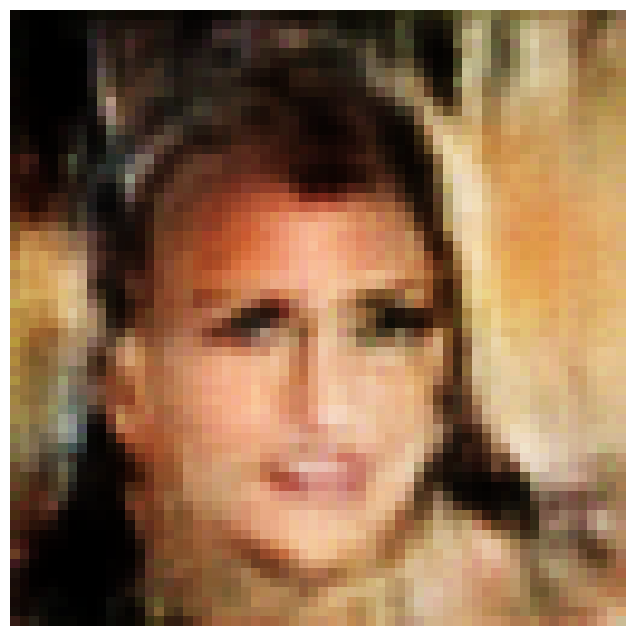

Epoch [36/50], Loss D: 0.3928048312664032, Loss G: 2.657283306121826
Epoch [37/50], Loss D: 0.4398610293865204, Loss G: 7.590202331542969
Epoch [38/50], Loss D: 2.897310733795166, Loss G: 0.7278475165367126
Epoch [39/50], Loss D: 0.92365562915802, Loss G: 10.974084854125977
Epoch [40/50], Loss D: 0.26444458961486816, Loss G: 5.391651153564453


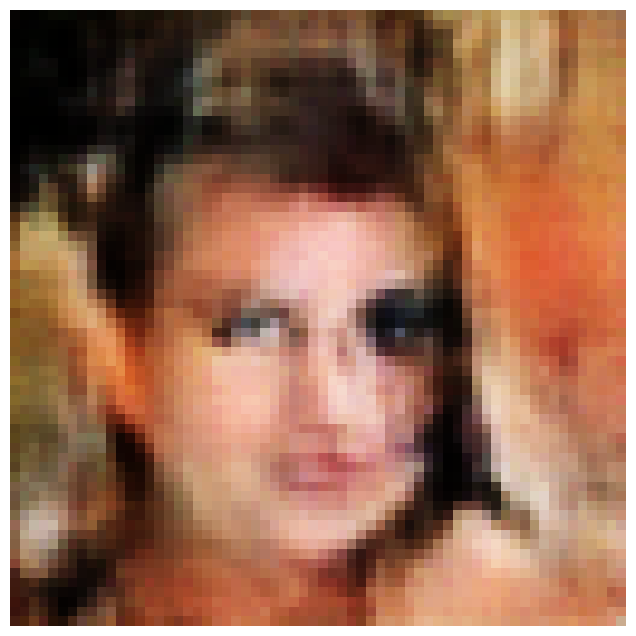

Epoch [41/50], Loss D: 1.4543644189834595, Loss G: 8.776867866516113
Epoch [42/50], Loss D: 0.9710935354232788, Loss G: 0.5595197677612305
Epoch [43/50], Loss D: 0.43724343180656433, Loss G: 7.5973968505859375
Epoch [44/50], Loss D: 0.1456575244665146, Loss G: 5.403986930847168
Epoch [45/50], Loss D: 0.3001108169555664, Loss G: 5.1906328201293945


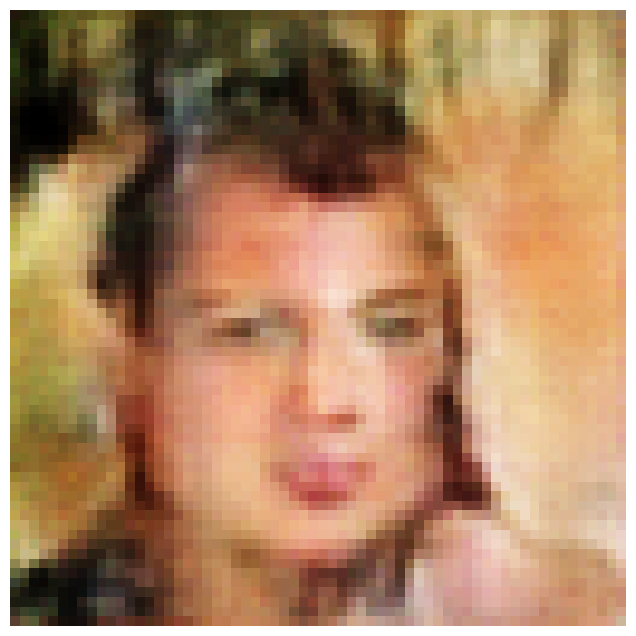

Epoch [46/50], Loss D: 0.15623119473457336, Loss G: 6.3938889503479
Epoch [47/50], Loss D: 0.5324525237083435, Loss G: 9.681018829345703
Epoch [48/50], Loss D: 0.19746753573417664, Loss G: 6.440960884094238
Epoch [49/50], Loss D: 0.5499756336212158, Loss G: 5.835188865661621
Epoch [50/50], Loss D: 0.2778834402561188, Loss G: 6.891077041625977


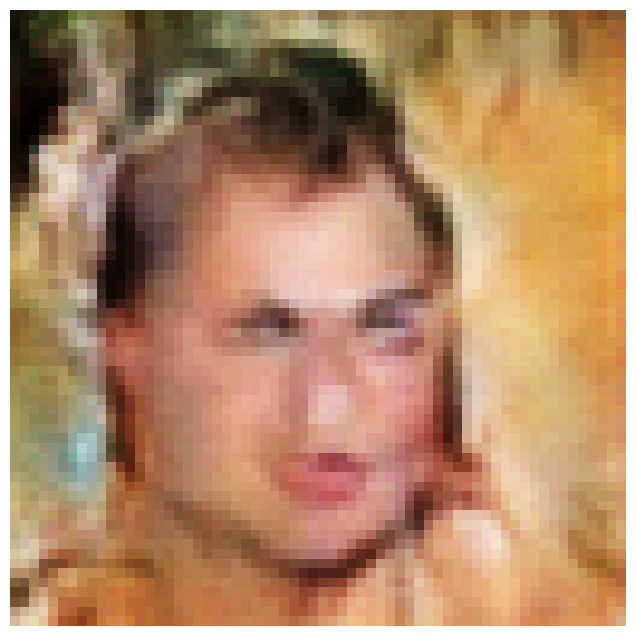

In [21]:
import numpy as np
import matplotlib.pyplot as plt

num_epochs = 50
fixed_noise = torch.randn(64, 100, 1, 1, device=device)  # Fixed noise for monitoring progress

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Move real images to device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        ## Train Discriminator ##
        netD.zero_grad()
        labels_real = torch.ones(batch_size, 1, device=device)  # Real labels = 1
        labels_fake = torch.zeros(batch_size, 1, device=device) # Fake labels = 0

        labels_real = torch.ones(batch_size, device=device).view(-1)  # Shape: (batch_size,)
        labels_fake = torch.zeros(batch_size, device=device).view(-1)  # Shape: (batch_size,)


        output_real = netD(real_images).view(-1)
        lossD_real = criterion(output_real, labels_real)

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output_fake, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ## Train Generator ##
        netG.zero_grad()
        labels_gen = torch.ones(batch_size, 1, device=device)  # Trick discriminator
        output_fake_G = netD(fake_images).view(-1)

        labels_gen = torch.ones(batch_size, 1, device=device)  # Shape: (128, 1)
        output_fake_G = netD(fake_images).view(-1, 1)  # Reshape to (128, 1)




        lossG = criterion(output_fake_G, labels_gen)

        lossG.backward()
        optimizerG.step()

    # Print loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {lossD.item()}, Loss G: {lossG.item()}")

    # Save and visualize generated images
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            fake_images_fixed = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.imshow(np.transpose(fake_images_fixed[0], (1, 2, 0)) * 0.5 + 0.5)
        plt.show()


In [22]:
torch.save(netG.state_dict(), "dcgan_celeba_generator.pth")
torch.save(netD.state_dict(), "dcgan_celeba_discriminator.pth")


<ipython-input-23-7f32a30f2eed>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load("dcgan_celeba_generator.pth"))


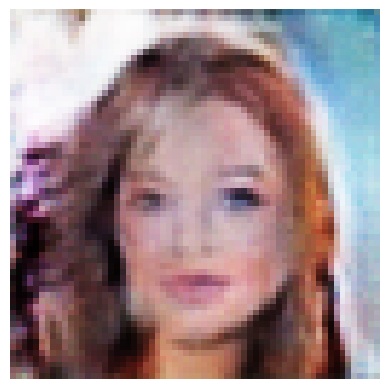

In [23]:
netG.load_state_dict(torch.load("dcgan_celeba_generator.pth"))
netG.eval()

noise = torch.randn(1, 100, 1, 1, device=device)
generated_face = netG(noise).detach().cpu()

plt.imshow(np.transpose(generated_face[0], (1, 2, 0)) * 0.5 + 0.5)
plt.axis("off")
plt.show()